# This is the third of three notebooks dedicated to the assignment Segmenting and Clustering Neighborhoods in Toronto. In this notebook I explore the non-food venues of Toronto.

__Import necessary libraries__

In [1]:

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import numpy as np


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.1
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    certifi-2020.11.8          |   py36h5fab9bb_0         150 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         392 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch

__Read table of neighborhoods and coordinates done in previous notebook__

In [4]:
df_neigh_coord = pd.read_csv('df_neig_coord.csv')
df_neigh_coord.rename(columns={"Neighbourhood": "Neighborhood"}, inplace=True)

In [18]:
df_neigh_coord.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


__Present map of Toronto neighborhoods__

In [5]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [6]:
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_neigh_coord['Latitude'], df_neigh_coord['Longitude'], df_neigh_coord['Borough'], df_neigh_coord['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

__Get venues dataframe from Foursquare for Toronto__

In [21]:
CLIENT_ID = 'Z4XVB323Q3LSL01P33QS4N4RAVTTWNUBAQQLXILWPT302B4Q' # your Foursquare ID
CLIENT_SECRET = 'VC1OHEWBNQEHAQ5KBUVOQNFECCER2H0IY2LRPOX0NRTTVYIU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT) 
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['location']['formattedAddress']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue City']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names=df_neigh_coord['Neighborhood'], latitudes=df_neigh_coord['Latitude'], longitudes=df_neigh_coord['Longitude'])

__Remove rows containing non-Toronto neighborhoods__

In [24]:
rows_to_drop = [index for index, row in toronto_venues.iterrows() if 'Toronto' not in str(toronto_venues['Venue City'].iloc[index])]
toronto_venues.drop(index=rows_to_drop,columns=['Venue City'], inplace=True)

In [372]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
9,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
10,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot


In [83]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 256 uniques categories.


In [97]:
toronto_venues.drop(columns=['index'],inplace=True)
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot


__Select only non-eating venues__

In [479]:
food_venues = ['Food', 'Candy', 'Cheese','Fruit','Vegetable','Wings','Coffee','Chocolate','Donut','Breakfast', 'Dinner', 'Lunch', 'Restaurant', 'Cafe', 'Pizza', 'Sandwich', 'Bakery', 'Café', 'Chicken', 'Beef', 
               'Burrito','Grocery','Burger', 'Yogurt', 'Fish', 'Steakhouse', 'Butcher', 'Creperie', 'Salad','Bistro', 'Dessert', 'Diner', 'Noodle', 'Sushi', 'Ice Cream', 'BBQ', 'Bagel', 'Deli', 'Bodega','Cupcake']
food_rows = [index for index,row in toronto_venues.iterrows() for food in food_venues  if  food  in str(row['Venue Category'])]
non_food_toronto_venues = toronto_venues.drop(toronto_venues.index[food_rows])
print(non_food_toronto_venues.shape)
non_food_toronto_venues.head()

(870, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
9,Scarborough Village,43.744734,-79.239476,Daisy Mart Convenience Store,43.743780,-79.244644,Smoke Shop
10,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,TTC Bus #68 Warden,43.711778,-79.279714,Bus Line


__Convert cathegorical variables to features by one-hot methodology__

In [480]:
## one hot encoding
toronto_onehot = pd.get_dummies(non_food_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = non_food_toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Baby Store,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Boat or Ferry,Bookstore,Boutique,Brewery,Bubble Tea Shop,Building,Bus Line,Bus Station,Business Service,Camera Store,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Auditorium,College Gym,College Rec Center,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Curling Ice,Dance Studio,Department Store,Discount Store,Distribution Center,Dive Bar,Dog Run,Electronics Store,Escape Room,Event Space,Farmers Market,Field,Flea Market,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Lake,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,Nightclub,Office,Opera House,Optical Shop,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Record Shop,Recording Studio,Rental Car Location,Road,Roof Deck,Sake Bar,Salon / Barbershop,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Strip Club,Supermarket,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Warehouse Store,Wine Bar,Women's Store
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Scarborough Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Clairlea,Golden Mile,Oakridge",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [481]:
toronto_onehot.shape

(870, 165)

__Now we group by neighborhoods__

In [487]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Workshop,Baby Store,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Boat or Ferry,Bookstore,Boutique,Brewery,Bubble Tea Shop,Building,Bus Line,Bus Station,Business Service,Camera Store,Church,Climbing Gym,Clothing Store,Cocktail Bar,College Arts Building,College Auditorium,College Gym,College Rec Center,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Curling Ice,Dance Studio,Department Store,Discount Store,Distribution Center,Dive Bar,Dog Run,Electronics Store,Escape Room,Event Space,Farmers Market,Field,Flea Market,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Lake,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Men's Store,Metro Station,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Venue,Nightclub,Office,Opera House,Optical Shop,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Pub,Record Shop,Recording Studio,Rental Car Location,Road,Roof Deck,Sake Bar,Salon / Barbershop,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Strip Club,Supermarket,Tailor Shop,Tanning Salon,Tea Room,Tennis Court,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Warehouse Store,Wine Bar,Women's Store
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.020833,0.0,0.0,0.020833,0.020833,0.0,0.0,0.083333,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.020833,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,

In [488]:
toronto_grouped.shape

(84, 165)

__Choose for each neighborhood 10th most popular non-food venues__

In [510]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [511]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))     

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Gym,Hotel,Clothing Store,Bar,Cosmetics Shop,Juice Bar,Concert Hall,Office,Bookstore,Women's Store
1,Agincourt,Lounge,Skating Rink,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Liquor Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
3,"Alderwood,Long Branch",Pharmacy,Gym,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
4,"Bathurst Manor,Downsview North,Wilson Heights",Shopping Mall,Mobile Phone Shop,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar


__Now, we'll find the clusters by means of kmeans algorithm, and choose the optimal k according to elbow method__

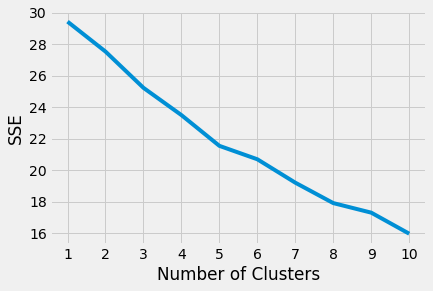

5

In [512]:
import matplotlib.pyplot as plt
from kneed import KneeLocator

max_kclusters = 11

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
sse = []
for kclusters in range(1, max_kclusters):
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    sse.append(kmeans.inertia_)
clust_range = range(1,max_kclusters)   
plt.style.use("fivethirtyeight")
plt.plot(clust_range, sse)
plt.xticks(clust_range)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

kl = KneeLocator(clust_range, sse, curve="convex", direction="decreasing")
k_opt = kl.elbow
k_opt

In [513]:
kmeans = KMeans(n_clusters=k_opt, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 4, 1], dtype=int32)

In [514]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Gym,Hotel,Clothing Store,Bar,Cosmetics Shop,Juice Bar,Concert Hall,Office,Bookstore,Women's Store
1,Agincourt,Lounge,Skating Rink,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
2,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Liquor Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
3,"Alderwood,Long Branch",Pharmacy,Gym,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
4,"Bathurst Manor,Downsview North,Wilson Heights",Shopping Mall,Mobile Phone Shop,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar


__Merge toronto_grouped and toronto data with neighborhood coordinates, and add cluster labels__

In [515]:
toronto_merged = df_neigh_coord
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Bar,Women's Store,Dive Bar,Flea Market,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Electronics Store,Intersection,Women's Store,Discount Store,Field,Farmers Market,Event Space,Escape Room,Dog Run,Dive Bar
3,M1G,Scarborough,Woburn,43.770992,-79.216917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [516]:
rows_with_nan = [index for index, row in toronto_merged.iterrows() if row.isnull().any()]
toronto_merged.drop(rows_with_nan,inplace=True)
toronto_merged.sort_values(by='Neighborhood', inplace=True)
toronto_merged.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged.head()

,Cluster Labels,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,1,M5H,Downtown Toronto,"Adelaide,King,Richmond",43.650571,-79.384568,Gym,Hotel,Clothing Store,Bar,Cosmetics Shop,Juice Bar,Concert Hall,Office,Bookstore,Women's Store
12,1,M1S,Scarborough,Agincourt,43.794200,-79.262029,Lounge,Skating Rink,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
101,1,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,Liquor Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
89,1,M8W,Etobicoke,"Alderwood,Long Branch",43.602414,-79.543484,Pharmacy,Gym,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
28,1,M3H,North York,"Bathurst Manor,Downsview North,Wilson Heights",43.754328,-79.442259,Shopping Mall,Mobile Phone Shop,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar


In [517]:
toronto_merged.shape

(84, 16)

__Show clusters on map__

In [518]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
kclusters = k_opt
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(ys)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

[array([0, 1, 2, 3]), array([ 1,  3,  7, 13]), array([ 2,  7, 20, 41]), array([ 3, 13, 41, 87]), array([  4,  21,  70, 151])]


__Show clusters dataframes__

In [519]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,M6E,York,Caledonia-Fairbanks,Park,Women's Store,Pool,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
75,M6G,Downtown Toronto,Christie,Park,Baby Store,Nightclub,Athletics & Sports,Women's Store,Dive Bar,Field,Farmers Market,Event Space,Escape Room
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",Bus Line,Bus Station,Metro Station,Park,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
45,M4P,Central Toronto,Davisville North,Hotel,Park,Gym / Fitness Center,Dog Run,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store
31,M3L,North York,Downsview West,Hotel,Shopping Mall,Park,Women's Store,Discount Store,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
64,M5P,Central Toronto,"Forest Hill North,Forest Hill West",Jewelry Store,Trail,Park,Women's Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
72,M6B,North York,Glencairn,Pub,Park,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",Bus Line,Fountain,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar,Distribution Center
44,M4N,Central Toronto,Lawrence Park,Bus Line,Park,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar,Distribution Center
25,M3A,North York,Parkwoods,Park,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar,Distribution Center


In [520]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,M5H,Downtown Toronto,"Adelaide,King,Richmond",Gym,Hotel,Clothing Store,Bar,Cosmetics Shop,Juice Bar,Concert Hall,Office,Bookstore,Women's Store
12,M1S,Scarborough,Agincourt,Lounge,Skating Rink,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Liquor Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
89,M8W,Etobicoke,"Alderwood,Long Branch",Pharmacy,Gym,Women's Store,Discount Store,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
28,M3H,North York,"Bathurst Manor,Downsview North,Wilson Heights",Shopping Mall,Mobile Phone Shop,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
62,M5M,North York,"Bedford Park,Lawrence Manor East",Pharmacy,Locksmith,Liquor Store,Pub,Juice Bar,Distribution Center,Event Space,Escape Room,Electronics Store,Dog Run
56,M5E,Downtown Toronto,Berczy Park,Beer Bar,Cocktail Bar,Farmers Market,Jazz Club,Park,Pharmacy,Museum,Department Store,Pub,Liquor Store
9,M1N,Scarborough,"Birch Cliff,Cliffside West",Skating Rink,General Entertainment,Women's Store,Distribution Center,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
78,M6K,West Toronto,"Brockton,Exhibition Place,Parkdale Village",Nightclub,Playground,Intersection,Convenience Store,Climbing Gym,Bookstore,Pet Store,Furniture / Home Store,Bar,Stadium
87,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,Comic Shop,Recording Studio,Garden,Garden Center,Brewery,Light Rail Station,Auto Workshop,Farmers Market,Skate Park,Gym / Fitness Center


In [521]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]


,Postcode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,M1W,Scarborough,L'Amoreaux West,Playground,Flea Market,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar,Distribution Center,Discount Store
48,M4T,Central Toronto,"Moore Park,Summerhill East",Playground,Flea Market,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar,Distribution Center,Discount Store


In [522]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",Bar,Women's Store,Dive Bar,Flea Market,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run
102,M9W,Etobicoke,Northwest,Bar,Women's Store,Dive Bar,Flea Market,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run


In [523]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]

,Postcode,Borough,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M9C,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Convenience Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
40,M4J,East York,East Toronto,Convenience Store,Women's Store,Distribution Center,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run,Dive Bar
81,M6N,York,"The Junction North,Runnymede",Convenience Store,Brewery,Women's Store,Dive Bar,Field,Farmers Market,Event Space,Escape Room,Electronics Store,Dog Run


__Create list of clusters dataframes__

In [530]:
clusters_df = []
for k in range(k_opt):
    clusters_df.append(toronto_merged.loc[toronto_merged['Cluster Labels'] == k, toronto_merged.columns[[1,2,3] + list(range(6, toronto_merged.shape[1]))]]) 

__Print a number of unique non-food venues in each cluster__

In [538]:
lens=[]
col_names_list = toronto_merged.columns.shape
for k in range(k_opt):
    index_new = np.unique(clusters_df[k].iloc[:,3:-1].values)
    df_list = pd.DataFrame(index=index_new)
    for i in range(len(col_names_list)-3):    
        df_list[i] = (clusters_df[k][col_names_list[i]].value_counts())
    cluster_cumsum = df_list.fillna(0).sum(axis=1)
    cluster_cumsum.sort_values()
    lens.append(len(index_new))
    print('Cluster {} contains {} unique venues in {} neighborhoods \n'.format(k, lens[-1], clusters_df[k].shape[0]))


Cluster 0 contains 27 unique venues in 12 neighborhoods 

Cluster 1 contains 129 unique venues in 65 neighborhoods 

Cluster 2 contains 9 unique venues in 2 neighborhoods 

Cluster 3 contains 9 unique venues in 2 neighborhoods 

Cluster 4 contains 11 unique venues in 3 neighborhoods 



__Bar plot for each cluster with 10 most popular non-food venues__

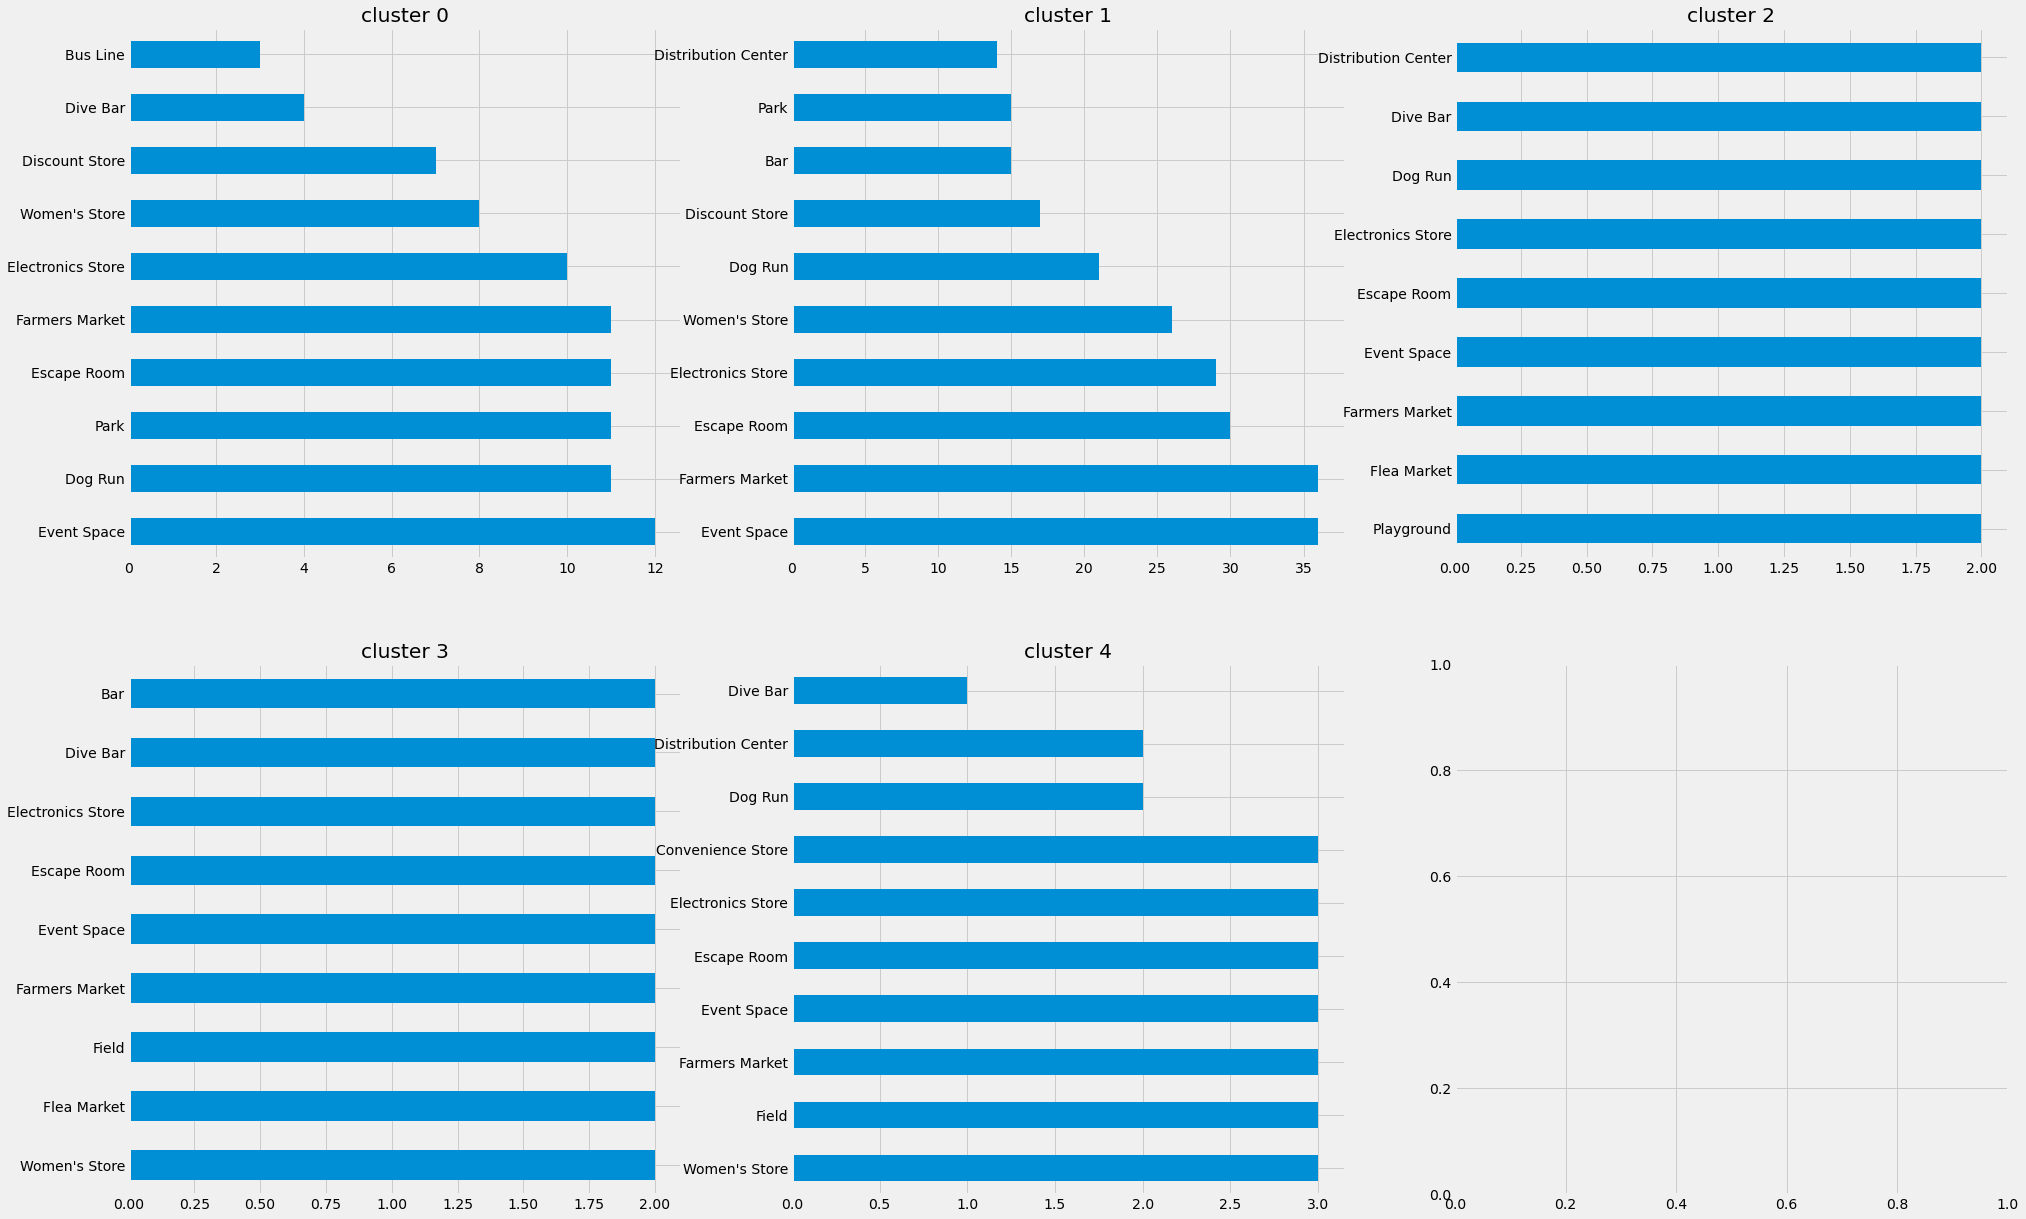

In [539]:
pairs = [(i,j) for i in range(2) for j in range(3)]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))
for k in range(k_opt):
    col_names_list = list(clusters_df[k].columns)[3:-1]
    index_new = np.unique(clusters_df[k].iloc[:,3:-1].values)
    df_list = pd.DataFrame(index=index_new)
    for i in range(len(col_names_list)):    
        df_list[i] = (clusters_df[k][col_names_list[i]].value_counts())
    cluster_cumsum = df_list.fillna(0).sum(axis=1)
    cluster_cumsum.sort_values(ascending=False, inplace=True)
    cluster_cumsum.head(10).plot(kind='barh', ax=axs[pairs[k]], title='cluster {}'.format(k))
  
fig.show()
